In [7]:
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score

import os
os.chdir('/mnt/ialabnas/homes/fidelrio/systematic-text-representations/')

from collections import defaultdict
from itertools import product
import json
from pathlib import Path
import random
import scipy
import pprint


from config import load_config
from data import build_datasets, build_loader, build_detailed_test_dataloaders
from data import CollatorForMaskedSelectedTokens, CollatorForMaskedRandomSelectedTokens, IdentityCollator
from data import ALL_POSSIBLE_COLORS
from model import MultimodalModel, MultimodalPretrainingModel
from utils import load_checkpoint
from lightning import Trainer, seed_everything
from tqdm.auto import tqdm, trange

from PIL import Image

import torch
from torch.utils.data import DataLoader, Subset
from torch.nn.functional import softmax

import numpy as np
from sklearn.decomposition import PCA



import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.dpi'] = 130
mpl.rcParams['font.size'] = 7
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['figure.dpi'] = 120

pp = pprint.PrettyPrinter(indent=2)

In [45]:
def read_metric(result, category, metric):
    if metric == 'random_baseline':
        return result['random_baseline'][category]
    
    metric_mode = 'random_without_testing_spheres'
    
    metric_idx, metric_name = {
        f'test_acc': (0, 'test_acc/dataloader_idx_0'),
        f'systematic_test_acc': (1, 'systematic_test_acc/dataloader_idx_1'),
        f'common_systematic_test_acc': (3, 'common_systematic_test_acc/dataloader_idx_1'),
        f'train_acc': (2, 'train_acc/dataloader_idx_0'),
    }[metric]
    
    return result[metric_mode][category][metric_idx][metric_name]


def get_num_colors(base_path):
    if 'colored' not in base_path:
        return 8
    num_colors = int(base_path.split('/')[-1][:-1])
    return num_colors


class ExperimentSuite:
    def __init__(self, exp_dicts):
        self.experiments = []
        self.indexed_experiments = {}
        for exp_dict in exp_dicts:
            self.append_experiment(exp_dict)
        
    def append_experiment(self, exp_dict):
        exp_name = self.standarize_name(exp_dict['exp_name'])
        if exp_name in self.indexed_experiments:
            base_exp = self.indexed_experiments[exp_name]
            base_exp.update_with(exp_dict)
            return
            
        exp = Experiment.from_dict(exp_dict)
        self.indexed_experiments[exp_name] = exp
        self.experiments.append(exp)
        
    def standarize_name(self, exp_name):
        return exp_name.split('--seed=')[0]
    
    @property
    def experiment_names(self):
        return list(self.indexed_experiments.keys())
    
    def get_exp(self, exp_name):
        return self.indexed_experiments[exp_name]
    
    def read_exp_metric(self, exp_name_or_names, task, metric, mode='random_without_testing_spheres', return_std=False):
        if isinstance(exp_name_or_names, list):
            exp_names = exp_name_or_names
            result = [
                self.get_exp(exp_name).read_metric(task, metric, mode=mode, return_std=return_std)
                for exp_name in exp_names
            ]
            if return_std:
                return list(zip(*result))
            return result
            
        exp_name = exp_name_or_names
        return self.get_exp(exp_name).read_metric(
            task, metric, mode=mode, return_std=return_std)


class Experiment:
    result_keys = ['selected', 'random', 'random_baseline', 'random_without_testing_spheres']
    
    def __init__(self, exp_name, config, runs):
        self.exp_name = exp_name
        self.config = config
        self.runs = runs
        
    @classmethod
    def from_dict(cls, experiment_dict):
        exp_name = experiment_dict['exp_name']
        config = experiment_dict['config']
        seed = config['seed']
        results = {k: experiment_dict[k] for k in cls.result_keys}
        return cls(exp_name, config, [ExperimentRun(seed, results)])
    
    def update_with(self, experiment_dict):
        new_config = experiment_dict['config']
        self._check_updating_config(new_config)
        seed = new_config['seed']
        results = {k: experiment_dict[k] for k in self.result_keys}
        self.runs.append(ExperimentRun(seed, results))
        
    def _check_updating_config(self, new_cofig):
        # Check config are the same or raise warning
        print('_check_updating_config not implemented yet.')
        
    def read_metric(self, task, metric, mode='random_without_testing_spheres', return_std=False):
        result = []
        for run in self.runs:
            result.append(self.read_metric_from(run, task, metric, mode=mode))
            
        if return_std:
            return np.mean(result), np.std(result)
        return np.mean(result)
        
    def read_metric_from(self, result, task, metric, mode='random_without_testing_spheres'):
        if metric == 'random_baseline':
            return result['random_baseline'][task]

        metric_idx, metric_name = {
            f'test_acc': (0, 'test_acc/dataloader_idx_0'),
            f'systematic_test_acc': (1, 'systematic_test_acc/dataloader_idx_1'),
            f'common_systematic_test_acc': (3, 'common_systematic_test_acc/dataloader_idx_1'),
            f'train_acc': (2, 'train_acc/dataloader_idx_0'),
        }[metric]

        return result[mode][task][metric_idx][metric_name]
        
    @property
    def categories(self):
        return list(self.runs[0].results['selected'].keys())
        
class ExperimentRun:
    def __init__(self, seed, results):
        self.seed = seed
        self.results = results
        
    def __getitem__(self, idx):
        return self.results[idx]
    
    def __len__(self):
        return len(self.results)

In [46]:
filter_experiments = lambda p: 'mmlm--n_colors=' in p.stem

results_dir = Path('outputs/results/')
all_results = [
    {'exp_name': p.stem, **json.load(p.open())} for p in results_dir.glob('*.json')
    if filter_experiments(p)
]

# all_results

In [4]:
def update_result_from(exp_name, k, v):
    with open(f'outputs/results/{exp_name}.json') as fp:
        results = json.load(fp)
        
    results[k] = v
    
    with open(f'outputs/results/{exp_name}.json', 'w') as fp:
        json.dump(results, fp)

def to_writable(scores): 
    return {f'{k[0]}:{k[1]}': v for k, v in scores.items()}

In [10]:
# config = load_config()
# config.multimodal_pretraining = True

n_samples = 5_000
use_complete_dataset = False

finished_exps = []
missing_exps = []
nmi_scores = {}
all_nmi_scores = defaultdict(dict)
for exp_name in ['mmlm--n_colors=216d4--mlm_probability=0.15--seed=32263']:
# for result_file in tqdm(list(Path('outputs/results').glob('mmlm-*.json'))):
#     exp_name = result_file.stem
    config = load_config(exp_name)
    config.vocabulary_path = config.vocabulary_path.replace('/workspace/', '/workspace1/')
    config.base_path = config.base_path.replace('/workspace/', '/workspace1/')
    if not os.path.exists(config.base_path):
        print(exp_name, 'not in hydra')
        missing_exps.append(exp_name)
        continue
        
#     with result_file.open() as fp:
#         results = json.load(fp)
        
#     if 'nmi_scores' in results:
#         print('skipping', exp_name)
#         finished_exps.append(exp_name)
#         continue
        
    
#     config.vocabulary_path = f'/workspace1/fidelrio/CLEVR_CoGenT_v1.0/colored-v2/{n_colors}/vocab.txt'
#     config.base_path = f'/workspace1/fidelrio/CLEVR_CoGenT_v1.0/colored-v2/{n_colors}'

    train_dataset, test_dataset, systematic_dataset, common_systematic_dataset = build_datasets(config)
    config.pad_idx = train_dataset.pad_idx
    config.n_tokens = train_dataset.n_tokens

    pad_idx = train_dataset.processor.vocabulary['[PAD]']

    data_to_iterate = train_dataset
    if not use_complete_dataset:
        indexes = random.sample(list(range(len(train_dataset))), k=n_samples)
        train_subset = Subset(train_dataset, indexes)
        data_to_iterate = train_subset
        
    loader = DataLoader(data_to_iterate, batch_size=64, num_workers=4)

    all_sizes = []
    all_colors = []
    all_materials = []
    all_shapes = []
    for _, scene in tqdm(loader):
        sizes = scene[:,1:][:,0::5]
        colors = scene[:,1:][:,1::5]
        materials = scene[:,1:][:,2::5]
        shapes = scene[:,1:][:,3::5]
        
        sizes = sizes[sizes != pad_idx].numpy()
        colors = colors[colors != pad_idx].numpy()
        materials = materials[materials != pad_idx].numpy()
        shapes = shapes[shapes != pad_idx].numpy()
        
        all_sizes.append(sizes)
        all_colors.append(colors)
        all_materials.append(materials)
        all_shapes.append(shapes)

    all_sizes = np.concatenate(all_sizes)
    all_colors = np.concatenate(all_colors)
    all_materials = np.concatenate(all_materials)
    all_shapes = np.concatenate(all_shapes)

    task_variables = [
        ('size', all_sizes), ('color', all_colors), ('material', all_materials), ('shape', all_shapes)]

    nmi_scores[exp_name] = normalized_mutual_info_score(all_colors, all_shapes)
    for (task0_name, task0_variables), (task1_name, task1_variables) in product(task_variables, repeat=2):
#         all_nmi_scores[exp_name][task0_name, task1_name] = normalized_mutual_info_score(
#                                                                 task0_variables, task1_variables)

        all_nmi_scores[exp_name][task0_name, task1_name], _ =  scipy.stats.pearsonr(
                                                                task0_variables, task1_variables)
        
#     writable_nmi_scores = to_writable(all_nmi_scores[exp_name])
#     update_result_from(exp_name, 'nmi_scores', writable_nmi_scores)

Loading mmlm--n_colors=216d4--mlm_probability=0.15--seed=32263 last checkpoint config from outputs/mmlm--n_colors=216d4--mlm_probability=0.15--seed=32263/last.ckpt


/home/fidelrio/.pyenv/versions/systematicity/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/79 [00:00<?, ?it/s]

In [11]:
print(len(missing_exps), missing_exps)

0 []


In [12]:
all_experiments = ExperimentSuite(all_results)

_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.


In [13]:
filter_to_overloading = lambda en: '--overloading' in en and not 'indep' in en
filter_to_underloading = lambda en: '--overloading' in en and 'indep' in en
filter_to_underloading_indep = lambda en: '--overloading' in en and 'indep' in en and 'no-indep' not in en
filter_to_underloading_no_indep = lambda en: '--overloading' in en and 'indep' in en and 'no-indep' in en
filter_to_capacity = lambda en: '--d_hidden' in en
filter_to_base = lambda en: '--overloading' not in en and '--d_hidden' not in en
filter_to_num = lambda en, num: f'n_colors={num}' in en if num else True

overloading_exps = [en for en in all_experiments.experiment_names if '--overloading' in en]
capacity_exps = [en for en in all_experiments.experiment_names if '--d_hidden' in en]
base_exps = list(set(all_experiments.experiment_names) - set(overloading_exps) - set(capacity_exps))

by_ncolors_exps = {num: 
    [en for en in all_experiments.experiment_names if f'n_colors={num}' in en] for num in [8, 27, 64, 125, 216]}

is_valid = lambda en: en in all_nmi_scores and ('color', 'shape') in all_nmi_scores[en]

In [14]:
def get_scatter_info_from(exps):
    test_accs = all_experiments.read_exp_metric(exps, 'shapes', 'test_acc')
    syst_accs = all_experiments.read_exp_metric(exps, 'shapes', 'systematic_test_acc')
    shape_color_nmis = [all_nmi_scores[en]['color', 'shape'] for en in exps]
    return shape_color_nmis, test_accs, syst_accs

In [15]:
nmi_exps = [en for en in all_experiments.experiment_names if is_valid(en)]
shape_color_nmis, test_accs, syst_accs = get_scatter_info_from(nmi_exps)

plt.scatter(shape_color_nmis, test_accs, label='test')
plt.scatter(shape_color_nmis, syst_accs, label='systematic')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /home/fidelrio/.pyenv/versions/systematicity/lib/python3.7/site-packages/IPython/core/formatters │
│ .py:224 in catch_format_error                                                                    │
│                                                                                                  │
│    221 def catch_format_error(method, self, *args, **kwargs):                                    │
│    222 │   """show traceback on failed format call"""                                            │
│    223 │   try:                                                                                  │
│ ❱  224 │   │   r = method(self, *args, **kwargs)                                                 │
│    225 │   except NotImplementedError:                                                           │
│    226 │   │   # don't warn on NotImplementedErrors                                              │
│    227 │   │   return self._check_return(None, args[0])                                          │
│                                                                                                  │
│ /home/fidelrio/.pyenv/versions/systematicity/lib/python3.7/site-packages/IPython/core/formatters │
│ .py:341 in __call__                                                                              │
│                                                                                                  │
│    338 │   │   │   except KeyError:                                                              │
│    339 │   │   │   │   pass                                                                      │
│    340 │   │   │   else:                                                                         │
│ ❱  341 │   │   │   │   return printer(obj)                                                       │
│    342 │   │   │   # Finally look for special method names                                       │
│    343 │   │   │   method = get_real_method(obj, self.print_method)                              │
│    344 │   │   │   if method is not None:                                                        │
│                                                                                                  │
│ /home/fidelrio/.pyenv/versions/systematicity/lib/python3.7/site-packages/IPython/core/pylabtools │
│ .py:151 in print_figure                                                                          │
│                                                                                                  │
│   148 │   │   from matplotlib.backend_bases import FigureCanvasBase                              │
│   149 │   │   FigureCanvasBase(fig)                                                              │
│   150 │                                                                                          │
│ ❱ 151 │   fig.canvas.print_figure(bytes_io, **kw)                                                │
│   152 │   data = bytes_io.getvalue()                                                             │
│   153 │   if fmt == 'svg':                                                                       │
│   154 │   │   data = data.decode('utf-8')                                                        │
│                                                                                                  │
│ /home/fidelrio/.pyenv/versions/systematicity/lib/python3.7/site-packages/matplotlib/backend_base │
│ s.py:2290 in print_figure                                                                        │
│                                                                                                  │
│   2287 │   │   │   │   │   │   print_method, orientation=orientation)                            │
│   2288 │   │   │   │   )                                                                         │
│   2289 │   │   │   │   with getattr(renderer, "_draw_disabl

<Figure size 768x576 with 1 Axes>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


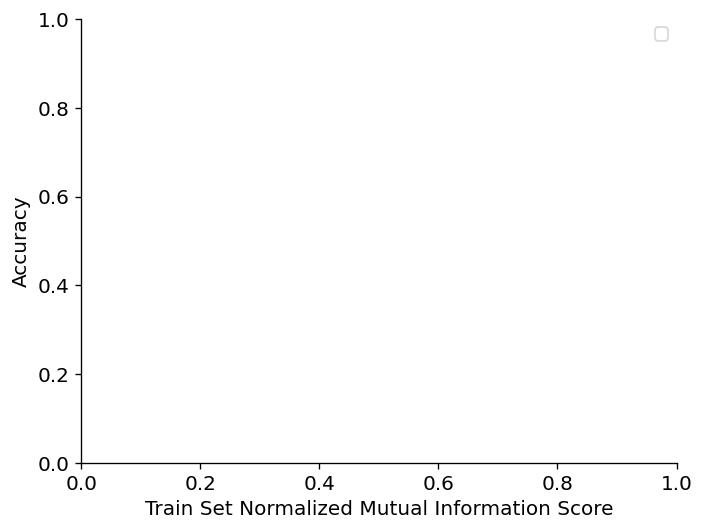

In [16]:
num_colors = 0

nmi_exps = [en for en in all_experiments.experiment_names
            if is_valid(en) and filter_to_num(en, num_colors) and filter_to_base(en)]
for en in nmi_exps:
    label = en.split('n_colors=')[-1].split('--')[0]
    shape_color_nmis, test_accs, syst_accs = get_catter_info_from([en])
    plt.scatter(shape_color_nmis, syst_accs, label=label)

# shape_color_nmis, test_accs, syst_accs = get_catter_info_from(nmi_exps)
# plt.scatter(shape_color_nmis, syst_accs, label='base')


# plt.xscale('log')
# plt.yscale('log')
plt.ylabel('Accuracy')
plt.xlabel('Train Set Normalized Mutual Information Score')
plt.legend()
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


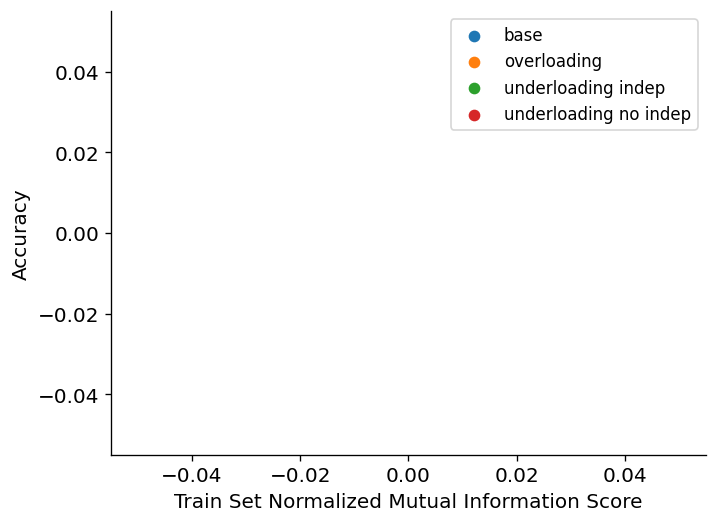

In [19]:
num_colors = 0

nmi_exps = [en for en in all_experiments.experiment_names
            if is_valid(en) and filter_to_num(en, num_colors) and filter_to_base(en)]
shape_color_nmis, test_accs, syst_accs = get_scatter_info_from(nmi_exps)
plt.scatter(shape_color_nmis, syst_accs, label='base')

nmi_exps = [en for en in all_experiments.experiment_names
            if is_valid(en) and filter_to_num(en, num_colors) and filter_to_overloading(en)]
shape_color_nmis, test_accs, syst_accs = get_scatter_info_from(nmi_exps)
plt.scatter(shape_color_nmis, syst_accs, label='overloading')

nmi_exps = [en for en in all_experiments.experiment_names
            if is_valid(en) and filter_to_num(en, num_colors) and filter_to_underloading_indep(en)]
shape_color_nmis, test_accs, syst_accs = get_scatter_info_from(nmi_exps)
plt.scatter(shape_color_nmis, syst_accs, label='underloading indep')

nmi_exps = [en for en in all_experiments.experiment_names
            if is_valid(en) and filter_to_num(en, num_colors) and filter_to_underloading_no_indep(en)]
shape_color_nmis, test_accs, syst_accs = get_scatter_info_from(nmi_exps)
plt.scatter(shape_color_nmis, syst_accs, label='underloading no indep')

# plt.xscale('log')
# plt.yscale('log')
plt.ylabel('Accuracy')
plt.xlabel('Train Set Normalized Mutual Information Score')
plt.legend()
plt.show()

In [21]:
num_colors = 216

overloading_value = lambda en: int(en.split('=')[-1].split('-')[0])

overloading_nmis = sorted([en for en in all_experiments.experiment_names
                           if is_valid(en) and filter_to_num(en, num_colors) and filter_to_overloading(en)],
                          key=overloading_value)

for en in overloading_nmis:
    label = str(en.split('=')[-1])
    shape_color_nmis, test_accs, syst_accs = get_scatter_info_from([en])
    plt.scatter(shape_color_nmis, syst_accs, label=label)
    

    
nmi_exps = [f'mmlm--n_colors={num_colors}c--mlm_probability=0.15']
shape_color_nmis, test_accs, syst_accs = get_scatter_info_from(nmi_exps)
plt.scatter(shape_color_nmis, syst_accs, label=f'{num_colors} (base)', marker='x')


underloading_nmis = sorted([en for en in all_experiments.experiment_names
                            if is_valid(en) and filter_to_num(en, num_colors) and filter_to_underloading(en)],
                           key=overloading_value)

for en in underloading_nmis:
    label = str(en.split('=')[-1])
    shape_color_nmis, test_accs, syst_accs = get_catter_info_from([en])
    plt.scatter(shape_color_nmis, syst_accs, label=label) 


# plt.xscale('log')
# plt.yscale('log')
plt.ylabel('Accuracy')
plt.xlabel('Train Set Normalized Mutual Information Score')
plt.legend()
plt.show()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:17                                                                                   │
│                                                                                                  │
│   14                                                                                             │
│   15                                                                                             │
│   16 nmi_exps = [f'mmlm--n_colors={num_colors}c--mlm_probability=0.15']                          │
│ ❱ 17 shape_color_nmis, test_accs, syst_accs = get_scatter_info_from(nmi_exps)                    │
│   18 plt.scatter(shape_color_nmis, syst_accs, label=f'{num_colors} (base)', marker='x')          │
│   19                                                                                             │
│   20                                                                                             │
│                                                                                                  │
│ in get_scatter_info_from:4                                                                       │
│                                                                                                  │
│   1 def get_scatter_info_from(exps):                                                             │
│   2 │   test_accs = all_experiments.read_exp_metric(exps, 'shapes', 'test_acc')                  │
│   3 │   syst_accs = all_experiments.read_exp_metric(exps, 'shapes', 'systematic_test_acc')       │
│ ❱ 4 │   shape_color_nmis = [all_nmi_scores[en]['color', 'shape'] for en in exps]                 │
│   5 │   return shape_color_nmis, test_accs, syst_accs                                            │
│   6                                                                                              │
│                                                                                                  │
│ in <listcomp>:4                                                                                  │
│                                                                                                  │
│   1 def get_scatter_info_from(exps):                                                             │
│   2 │   test_accs = all_experiments.read_exp_metric(exps, 'shapes', 'test_acc')                  │
│   3 │   syst_accs = all_experiments.read_exp_metric(exps, 'shapes', 'systematic_test_acc')       │
│ ❱ 4 │   shape_color_nmis = [all_nmi_scores[en]['color', 'shape'] for en in exps]                 │
│   5 │   return shape_color_nmis, test_accs, syst_accs                                            │
│   6                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: ('color', 'shape')

In [ ]:
assert False

In [ ]:
#################################################
#################################################
## UPDATE RESULT FILES WITH SAMPLED NMI SCORES ##
#################################################
#################################################

# def update_result_from(exp_name, k, v):
#     with open(f'outputs/results/{exp_name}.json') as fp:
#         results = json.load(fp)
        
#     results[k] = v
    
#     with open(f'outputs/results/{exp_name}.json', 'w') as fp:
#         json.dump(results, fp)

# for exp_name, scores in all_nmi_scores.items():
#     writable_nmi_scores = {f'{k[0]}:{k[1]}': v for k, v in scores.items()}
#     update_result_from(exp_name, 'sampled_nmi_scores', writable_nmi_scores)

In [ ]:
assert False

In [22]:
config = load_config()
config.multimodal_pretraining = True

n_samples = 5_000
use_complete_dataset = False

nmi_scores = {}
all_nmi_scores = defaultdict(dict)
# for n_colors in ['8c']:
for n_colors in ['8c', '8e1', '8e2', '8e3', '27c', '64c', '125c', '216c', '216d1', '216d2', '216d3', '216d4']:
    config.vocabulary_path = f'/workspace1/fidelrio/CLEVR_CoGenT_v1.0/colored-v2/{n_colors}/vocab.txt'
    config.base_path = f'/workspace1/fidelrio/CLEVR_CoGenT_v1.0/colored-v2/{n_colors}'

    train_dataset, test_dataset, systematic_dataset, common_systematic_dataset = build_datasets(config)
    config.pad_idx = train_dataset.pad_idx
    config.n_tokens = train_dataset.n_tokens

    pad_idx = train_dataset.processor.vocabulary['[PAD]']

    data_to_iterate = train_dataset
    if not use_complete_dataset:
        indexes = random.sample(list(range(len(train_dataset))), k=n_samples)
        train_subset = Subset(train_dataset, indexes)
        data_to_iterate = train_subset
        
    loader = DataLoader(data_to_iterate, batch_size=32, num_workers=4)

    all_sizes = []
    all_colors = []
    all_materials = []
    all_shapes = []
    for _, scene in tqdm(loader):
        sizes = scene[:,1:][:,0::5]
        colors = scene[:,1:][:,1::5]
        materials = scene[:,1:][:,2::5]
        shapes = scene[:,1:][:,3::5]
        
        sizes = sizes[sizes != pad_idx].numpy()
        colors = colors[colors != pad_idx].numpy()
        materials = materials[materials != pad_idx].numpy()
        shapes = shapes[shapes != pad_idx].numpy()
        
        all_sizes.append(sizes)
        all_colors.append(colors)
        all_materials.append(materials)
        all_shapes.append(shapes)

    all_sizes = np.concatenate(all_sizes)
    all_colors = np.concatenate(all_colors)
    all_materials = np.concatenate(all_materials)
    all_shapes = np.concatenate(all_shapes)

    task_variables = [
        ('size', all_sizes), ('color', all_colors), ('material', all_materials), ('shape', all_shapes)]

    nmi_scores[n_colors] = normalized_mutual_info_score(all_colors, all_shapes)
    for (task0_name, task0_variables), (task1_name, task1_variables) in product(task_variables, repeat=2):
#         all_nmi_scores[exp_name][task0_name, task1_name] = normalized_mutual_info_score(
#                                                                 task0_variables, task1_variables)

        all_nmi_scores[exp_name][task0_name, task1_name], _ =  scipy.stats.pearsonr(
                                                                task0_variables, task1_variables)

/home/fidelrio/.pyenv/versions/systematicity/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/157 [00:00<?, ?it/s]

/home/fidelrio/.pyenv/versions/systematicity/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/157 [00:00<?, ?it/s]

/home/fidelrio/.pyenv/versions/systematicity/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/157 [00:00<?, ?it/s]

/home/fidelrio/.pyenv/versions/systematicity/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/157 [00:00<?, ?it/s]

/home/fidelrio/.pyenv/versions/systematicity/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/157 [00:00<?, ?it/s]

/home/fidelrio/.pyenv/versions/systematicity/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/157 [00:00<?, ?it/s]

/home/fidelrio/.pyenv/versions/systematicity/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/157 [00:00<?, ?it/s]

/home/fidelrio/.pyenv/versions/systematicity/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/157 [00:00<?, ?it/s]

/home/fidelrio/.pyenv/versions/systematicity/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/157 [00:00<?, ?it/s]

/home/fidelrio/.pyenv/versions/systematicity/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/157 [00:00<?, ?it/s]

/home/fidelrio/.pyenv/versions/systematicity/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/157 [00:00<?, ?it/s]

/home/fidelrio/.pyenv/versions/systematicity/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/157 [00:00<?, ?it/s]

In [23]:
(scene.shape,
 scene[1:][0::5].shape,
 scene[1:][1::5].shape,
 scene[1:][2::5].shape,
 scene[1:][3::5].shape,)

(torch.Size([8, 50]),
 torch.Size([2, 50]),
 torch.Size([2, 50]),
 torch.Size([1, 50]),
 torch.Size([1, 50]))

In [24]:
for k, v in nmi_scores.items():
    print(f'{k:5.5} : {v:.4f}')

8c    : 0.2900
8e1   : 0.0463
8e2   : 0.1058
8e3   : 0.1823
27c   : 0.0947
64c   : 0.0285
125c  : 0.0133
216c  : 0.0085
216d1 : 0.1430
216d2 : 0.0582
216d3 : 0.0307
216d4 : 0.0931


In [47]:
filter_experiments = lambda p: 'mmlm--n_colors=' in p.stem

results_dir = Path('outputs/results/')
all_results = [
    {'exp_name': p.stem, **json.load(p.open())} for p in results_dir.glob('*.json')
    if filter_experiments(p)
]
all_experiments = ExperimentSuite(all_results)

_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.


In [48]:
experiment_group = [
    f'mmlm--n_colors={num_color}--mlm_probability=0.15' 
    for num_color in 
    ['8c', '8e1', '8e2', '27c', '64c', '125c', '216c', '216d1', '216d2', '216d3', '216d4']
]
xs = ['8c', '8e1', '8e2', '27c', '64c', '125c', '216c', '216d1', '216d2', '216d3', '216d4']
# xs = [8, 16, 32, 64, 128, 216, 512] 

color_tests = all_experiments.read_exp_metric(experiment_group, 'color', 'test_acc')
color_system = all_experiments.read_exp_metric(experiment_group, 'color', 'systematic_test_acc')
# colors_cmn_syst = all_experiments.read_exp_metric(experiment_group, 'color', 'common_systematic_test_acc')

shape_tests = all_experiments.read_exp_metric(experiment_group, 'shapes', 'test_acc')
shape_system = all_experiments.read_exp_metric(experiment_group, 'shapes', 'systematic_test_acc')

In [49]:
# shape_tests, shape_system, color_tests, color_system = (
#     (0.9841940999031067,
#      0.9754792153835297,
#      0.976220965385437,
#      0.9715898633003235,
#      0.9718354642391205),
#     (0.32786083221435547,
#      0.3437183052301407,
#      0.6528002917766571,
#      0.8655988276004791,
#      0.9318382143974304),
#     (0.9569357633590698,
#      0.9433647096157074,
#      0.9332085847854614,
#      0.9177844524383545,
#      0.9074549376964569),
#     (0.6936854720115662,
#      0.7998603284358978,
#      0.8158515989780426,
#      0.7642492055892944,
#      0.8363668918609619)
# )
shape_tests = np.array(shape_tests)
shape_system = np.array(shape_system)
color_tests = np.array(color_tests)
color_system = np.array(color_system)

In [50]:
nmi_scores_vals = np.array([nmi_scores[x] for x in xs])

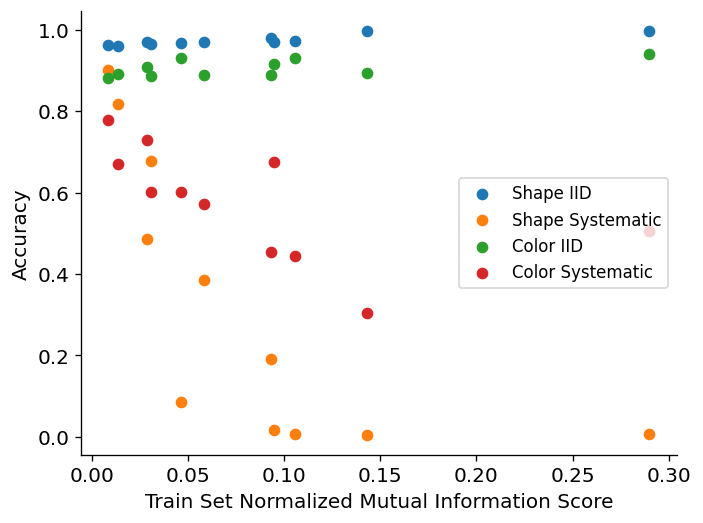

In [51]:
plt.scatter(nmi_scores_vals, shape_tests, label='Shape IID')
plt.scatter(nmi_scores_vals, shape_system, label='Shape Systematic')
plt.scatter(nmi_scores_vals, color_tests, label='Color IID')
plt.scatter(nmi_scores_vals, color_system, label='Color Systematic')

plt.legend(loc='center right')
plt.ylabel('Accuracy')
plt.xlabel('Train Set Normalized Mutual Information Score')

plt.show()

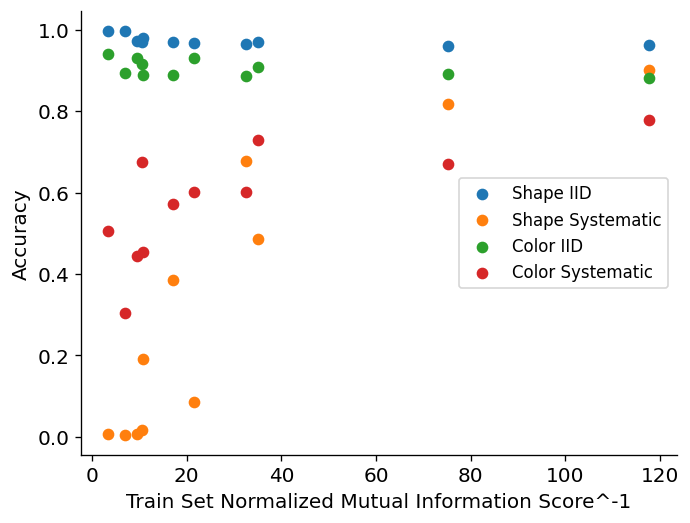

In [52]:
plt.scatter(1/nmi_scores_vals, shape_tests, label='Shape IID')
plt.scatter(1/nmi_scores_vals, shape_system, label='Shape Systematic')
plt.scatter(1/nmi_scores_vals, color_tests, label='Color IID')
plt.scatter(1/nmi_scores_vals, color_system, label='Color Systematic')

plt.legend(loc='center right')
plt.ylabel('Accuracy')
plt.xlabel('Train Set Normalized Mutual Information Score^-1')

plt.show()

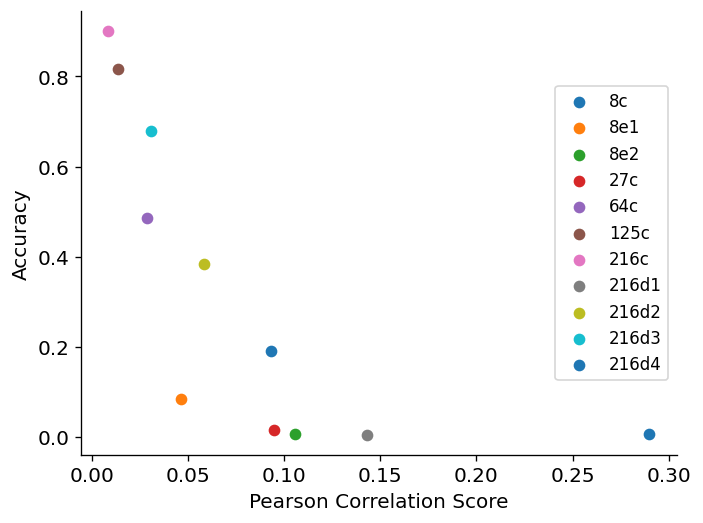

In [53]:
# plt.scatter(nmi_scores_vals, shape_tests, label='Shape IID')
# plt.scatter(nmi_scores_vals, shape_system, label='Shape Systematic')
# plt.scatter(nmi_scores_vals, color_tests, label='Color IID')

for i, x in enumerate(xs):
    plt.scatter(nmi_scores[x], shape_system[i], label=x)
#     plt.scatter(nmi_scores[x], color_system[i], label=x)

plt.legend(loc='center right')
plt.ylabel('Accuracy')
plt.xlabel('Pearson Correlation Score')
# plt.xlabel('Train Set Normalized Mutual Information Score')

plt.show()

In [32]:
tasks = ['size', 'color', 'material', 'shape']

_min = float('inf')
_max = float('-inf')

matrices = {}
for n_colors in ['8c', '27c', '64c', '125c', '216c']:
    matrix = np.empty((len(tasks), len(tasks)))
    for i, task0 in enumerate(tasks): 
        for j, task1 in enumerate(tasks):
            matrix[i,j] = all_nmi_scores[n_colors][task0, task1]
            
            if i == j:
                matrix[i,j] = 0
            else:
                _min = min(_min, matrix[i,j])
                _max = max(_max, matrix[i,j])
            
    matrices[n_colors] = matrix
    
# _min = min(m.min() for m in matrices.values())
# _max = max(m.max() for m in matrices.values())

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:11                                                                                   │
│                                                                                                  │
│    8 │   matrix = np.empty((len(tasks), len(tasks)))                                             │
│    9 │   for i, task0 in enumerate(tasks):                                                       │
│   10 │   │   for j, task1 in enumerate(tasks):                                                   │
│ ❱ 11 │   │   │   matrix[i,j] = all_nmi_scores[n_colors][task0, task1]                            │
│   12 │   │   │                                                                                   │
│   13 │   │   │   if i == j:                                                                      │
│   14 │   │   │   │   matrix[i,j] = 0                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: ('size', 'size')

In [33]:
fig = plt.figure(figsize=(9*0.75,5*0.75))

for idx, (n_colors, matrix) in enumerate(matrices.items(), start=1):
    ax = fig.add_subplot(2, 3, idx)  # equivalent but more general
    mat = ax.matshow(
        np.log(matrices[n_colors]), cmap=mpl.colormaps['Blues'], vmin=np.log(_min), vmax=np.log(_max))
#     mat = ax.matshow(
#         matrices[n_colors], cmap=mpl.colormaps['Blues'], vmin=_min, vmax=_max)
    if idx % 3 == 1:
        ax.set_yticks(range(len(tasks)), tasks)
    else:
        ax.set_yticks(range(len(tasks)), [""]*len(tasks))
    if idx < 4:
        ax.set_xticks(range(len(tasks)), tasks)
    else:
        ax.set_xticks(range(len(tasks)), [""]*len(tasks))
        
    ax.tick_params(axis='x', labelrotation=45)

#     fig.colorbar(mat, )
plt.show()

<Figure size 810x450 with 0 Axes>

In [34]:
np.tril(matrices['8c']), np.tril(matrices['216c'])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 np.tril(matrices['8c']), np.tril(matrices['216c'])                                           │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: '8c'